In [1]:
# load packages

import os
import numpy as np
import pandas as pd
from qsprpred.data import QSPRDataset
from sklearn.impute import SimpleImputer
from qsprpred.data import QSPRDataset, RandomSplit
from qsprpred.data.descriptors.fingerprints import MorganFP
from qsprpred.data.descriptors.sets import SmilesDesc
from qsprpred.data.sampling.splits import GBMTRandomSplit, GBMTDataSplit, ManualSplit
from split import random_global_equilibrated_random_split, dissimilaritydrive_global_balanced_cluster_split
from qsprpred.extra.gpu.models.chemprop import ChempropModel
from qsprpred.models import CrossValAssessor, TestSetAssessor
from qsprpred.models.early_stopping import EarlyStoppingMode
# from qsprpred.plotting.regression import CorrelationPlot
from plotting_regression_MT import CorrelationPlot

The history saving thread hit an unexpected error (OperationalError('no such table: history')).History will not be written to the database.


Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality


In [2]:
df=pd.read_csv('/home/s2861704/ppk/test_kin/output/TK/TK_split.csv', sep=',')
display(df)
print(df.columns)
print(type(df.loc[df.index[0], 'P00533']))

,SMILES,O60674,P00519,P00533,P04626,P04629,P06213,P06239,P07333,P07949,...,Q06187,Q06418,Q07912,Q08345,Q08881,Q12866,Q16288,Q16620,Q16832,split
0,BrC(Cn1ncc2c(N3CCCC3)ncnc21)c1ccccc1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train
1,BrC(Cn1ncc2c(N3CCCCC3)ncnc21)c1ccccc1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train
2,BrC(Cn1ncc2c(NCc3ccccc3)ncnc21)c1ccccc1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train
3,Brc1cc(CNc2ncc(Br)c(Nc3cc(C4CC4)[nH]n3)n2)on1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train
4,Brc1cc2c(NCc3ccccc3)ncnc2s1,NaN,NaN,6.62,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36999,c1nc2c(Nc3ccc(N4CCOCC4)cc3)nc(-c3ccc4c[nH]nc4c...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train
37000,c1nc2c(Nc3ccc(N4CCOCC4)cc3)nc(-c3ccc4c[nH]nc4c...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train
37001,c1ncc(-c2cc(CNc3nc(Nc4cc(C5CC5)[nH]n4)cc(N4CCO...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train
37002,c1ncc(CN2CCC(n3cnc4cnc5[nH]ccc5c43)CC2)cn1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train


Index(['SMILES', 'O60674', 'P00519', 'P00533', 'P04626', 'P04629', 'P06213',
       'P06239', 'P07333', 'P07949', 'P08069', 'P08581', 'P09581', 'P09619',
       'P10721', 'P11362', 'P12931', 'P16234', 'P17948', 'P21802', 'P22455',
       'P22607', 'P23458', 'P29317', 'P29597', 'P30530', 'P35968', 'P36888',
       'P43405', 'P52333', 'P54760', 'Q02763', 'Q05397', 'Q06187', 'Q06418',
       'Q07912', 'Q08345', 'Q08881', 'Q12866', 'Q16288', 'Q16620', 'Q16832',
       'split'],
      dtype='object')
<class 'numpy.float64'>


In [3]:
# print(len(df.columns))
# max_Nans = len(df.columns) - 5
# print(max_Nans)

In [3]:
targets_kinase200 = df.columns[1:42].tolist()
display(targets_kinase200)

['O60674',
 'P00519',
 'P00533',
 'P04626',
 'P04629',
 'P06213',
 'P06239',
 'P07333',
 'P07949',
 'P08069',
 'P08581',
 'P09581',
 'P09619',
 'P10721',
 'P11362',
 'P12931',
 'P16234',
 'P17948',
 'P21802',
 'P22455',
 'P22607',
 'P23458',
 'P29317',
 'P29597',
 'P30530',
 'P35968',
 'P36888',
 'P43405',
 'P52333',
 'P54760',
 'Q02763',
 'Q05397',
 'Q06187',
 'Q06418',
 'Q07912',
 'Q08345',
 'Q08881',
 'Q12866',
 'Q16288',
 'Q16620',
 'Q16832']

In [ ]:
# for target in targets_kinase200:
#     df.loc[df[target] < 10.5, target] = np.nan
# display(df)

,SMILES,O60674,P00519,P00533,P04626,P04629,P06213,P06239,P07333,P07949,...,Q06187,Q06418,Q07912,Q08345,Q08881,Q12866,Q16288,Q16620,Q16832,split
0,BrC(Cn1ncc2c(N3CCCC3)ncnc21)c1ccccc1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train
1,BrC(Cn1ncc2c(N3CCCCC3)ncnc21)c1ccccc1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train
2,BrC(Cn1ncc2c(NCc3ccccc3)ncnc21)c1ccccc1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train
3,Brc1cc(CNc2ncc(Br)c(Nc3cc(C4CC4)[nH]n3)n2)on1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train
4,Brc1cc2c(NCc3ccccc3)ncnc2s1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36999,c1nc2c(Nc3ccc(N4CCOCC4)cc3)nc(-c3ccc4c[nH]nc4c...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train
37000,c1nc2c(Nc3ccc(N4CCOCC4)cc3)nc(-c3ccc4c[nH]nc4c...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train
37001,c1ncc(-c2cc(CNc3nc(Nc4cc(C5CC5)[nH]n4)cc(N4CCO...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train
37002,c1ncc(CN2CCC(n3cnc4cnc5[nH]ccc5c43)CC2)cn1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train


In [ ]:
# pd.options.display.max_rows = 20
# pd.options.display.max_columns = None
# pd.options.display.max_colwidth = None
# df_pol = df.dropna(axis=0, thresh=4)
# display(df_pol)

,SMILES,O60674,P00519,P00533,P04626,P04629,P06213,P06239,P07333,P07949,P08069,P08581,P09581,P09619,P10721,P11362,P12931,P16234,P17948,P21802,P22455,P22607,P23458,P29317,P29597,P30530,P35968,P36888,P43405,P52333,P54760,Q02763,Q05397,Q06187,Q06418,Q07912,Q08345,Q08881,Q12866,Q16288,Q16620,Q16832,split
3922,CC(=O)N1CCCC(Nc2ncccc2-c2cnc3[nH]ccc3n2)C1,10.64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.890,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train
23277,CS(=O)(=O)N1CCC(Nc2ncccc2-c2cnc3[nH]ccc3n2)C1,10.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.865,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train


In [ ]:
# CUTOFF = pChEMBL 10.5
# 2+ (2)
#   1. CC(=O)N1CCCC(Nc2ncccc2-c2cnc3[nH]ccc3n2)C1 [3922]
#   2. CS(=O)(=O)N1CCC(Nc2ncccc2-c2cnc3[nH]ccc3n2)C1 [23277]
# 1+ (72)

In [ ]:
# CUTOFF = pChEMBL 10.0 (all except 7487 include target O60674, all except 7487, 23559, 34170 include P52333 )
# 2+ (20)
#   1. CC(=O)N1CCC(Nc2ncccc2-c2cnc3[nH]ccc3n2)C1 [3885]
#   2. CC(=O)N1CCCC(Nc2nc(C)ccc2-c2cnc3[nH]ccc3n2)C1 [3921]
#   3. CC(=O)N1CCCC(Nc2ncccc2-c2cnc3[nH]ccc3n2)C1 [3922]
#   4. CC(=O)N1CCCCC(Nc2ncccc2-c2cnc3[nH]ccc3n2)C1 [3929]
#   5. CC(C)CS(=O)(=O)N1CC(C)CC(Nc2nc(N3CCN(C)CC3)ncc2-c2cnc3[nH]ccc3n2)C1 [5133]
#   6. CC(C)CS(=O)(=O)N1CCCC(Nc2nc(N3CCOCC3)ncc2-c2cnc3[nH]ccc3n2)C1 [5142]
#   7. CC(C)CS(=O)(=O)N1CCCC(Nc2nccnc2-c2cnc3[nH]ccc3n2)C1 [5149]
#   8. CC1CNC(=O)c2cnn3ccc(nc23)NC(C)c2cc(F)ccc2O1 [7487]
#   9. CN(C)C1CCN(c2ncc(-c3cnc4[nH]ccc4n3)c(NC3CCCN(S(C)(=O)=O)C3)n2)C1 [11302]
#   10. COC(=O)N1CCCCC(Nc2ncccc2-c2cnc3[nH]ccc3n2)C1 [14850]
#   11. COCCNc1ncc(-c2cnc3[nH]ccc3n2)c(NC2CCCN(S(C)(=O)=O)C2)n1 [15647]
#   12. COc1ncc(-c2cnc3[nH]ccc3n2)c(NC2CCCN(S(C)(=O)=O)C2)n1 [23079]
#   13. CS(=O)(=O)N1CCC(Nc2ncccc2-c2cnc3[nH]ccc3n2)C1 [23277]
#   14. CS(=O)(=O)N1CCCC(Nc2nc(N3CC(C#N)C3)ncc2-c2cnc3[nH]ccc3n2)C1 [23294]
#   15. CS(=O)(=O)N1CCCC(Nc2ncccc2-c2cnc3[nH]cc(C4CC4)c3n2)C1 [23306]
#   16. CS(=O)(=O)N1CCCCC(Nc2ncccc2-c2cnc3[nH]ccc3n2)C1 [23322]
#   17. CSc1ccc(OC(F)F)c(-c2[nH]ncc2NC(=O)c2cnc3cccnn23)c1 [23559]
#   18. Cc1c[nH]c2ncc(-c3cccnc3NC3CCCN(S(C)(=O)=O)C3)nc12 [24157]
#   19. Cc1ccc(-c2cnc3[nH]ccc3n2)c(NC2CCCN(S(C)(=O)=O)C2)n1	[25444]
#   20. O=C(Nc1c[nH]nc1-c1cc2c[nH]nc2cc1OC(F)F)c1cnn2cccnc12 [34170]
# 1+ (257)

In [ ]:
# CUTOFF = pChEMBL 9.5
# 3+ (1)
#   1. COc1cc(OC)c(F)c(N2Cc3cnc4[nH]ccc4c3N(C)C2=O)c1F [18138]
# 2+ (76)
# 1+ (740)

In [ ]:
# CUTOFF = pChEMBL 9.0
# 4+ (1)
#   1. OCC(Nc1cnc(-c2cc(Cl)ccc2O)c(-c2ccc3cnccc3c2)c1)c1ccccc1 [36186]
# 3+ (16)
#   2. CC(C)n1cc(C(=O)Nc2ccc(Oc3ccnc(NC(=O)C4CC4)c3)c(F)c2)c(=O)n(-c2ccc(F)cc2)c1=O [5725]
#   3. CCc1cc(O)c(F)cc1-c1cc(NC(C)CO)c2nc(NCCCCCN(C)C)ncc2c1 [10501]
#   4. CCc1cc(O)c(F)cc1-c1cc(NC2CCN(C(C)=O)CC2)c2nc(N)ncc2c1 [10507]
#   5. CCc1cc(O)ccc1-c1ccc2c(-c3ncc[nH]3)[nH]nc2c1 [10565]
#   6. CN(c1ncnc2[nH]ccc12)C1CCC(CS(=O)(=O)N2CCCC(OP(=O)(O)O)C2)CC1	[12237]
#   7. CN1CCN(Cc2ccc(NC(=O)c3ccc(Cl)c(C#Cc4cncc(N5CCOCC5)c4)c3)cc2C(F)(F)F)CC1 [13036]
#   8. CNC(=O)n1ccc2cc(Oc3ccnc(NC(=O)c4ccc(C5CCN(CCO)CC5)cc4)c3)c(OCCO)cc21 [14359]
#   9. COc1cc(OC)c(Cl)c(N2Cc3cnc4[nH]ccc4c3N(C)C2=O)c1F [18095]
#   10. COc1cc(OC)c(F)c(COc2cnc(Nc3cnn(CCO)c3)nc2)c1F [18128]
#   11. COc1cc(OC)c(F)c(N2Cc3cnc4[nH]ccc4c3N(C)C2=O)c1F	[18138]
#   12. COc1cc(OC)cc(-c2nn(CCCCCN3CCN(C(=O)C=CC(F)(F)F)CC3)c3ncnc(N)c23)c1 [18184]
#   13. COc1cc2ncc(-c3cccc(NC4CCNC4)n3)n2cc1-c1cnn(C)c1	[19874]
#   14. Cc1[nH]nc2ccc(-c3cc(NC(CO)c4ccccc4)cnc3-c3ccc(F)cc3O)cc12 [23761]
#   15. Cc1cc(-c2cc(O)ccc2Cl)cc2nnc(Nc3ccc(OCCN4CCCC4)cc3)nc12 [24266]
#   16. Cc1cc2cnc3[nH]ccc3c2n1C1CN(C(=O)CC#N)CCC1C [25335]
# 2+ (235)
# 1+ (2477)

In [ ]:
# CUTOFF = pChEMBL 8.5
# 8+ (1)
#   1. CNC(=O)c1ncc(C#Cc2cc(C(=O)Nc3ccc(CN4CCN(CCO)CC4)c(C(F)(F)F)c3)ccc2C)n1C [14272]
# 7+ (2)
#   2. Cc1cc(-c2cc(O)ccc2Cl)cc2nnc(Nc3ccc(OCCN4CCCC4)cc3)nc12 [24266]
# 6+ (2)
# 5+ (5)
#   3. CCN(CC)CCNC(=O)c1c(C)[nH]c2c1=CCCC=2c1c(O)[nH]c2ccc(F)cc12 [8734]
#   4. CNC1CC2OC(C1OC)n1c3ccccc3c3c4c(c5c6ccccc6n2c5c31)C(=O)NC4 [14404]
#   5. OCC(Nc1cnc(-c2cc(Cl)ccc2O)c(-c2ccc3cnccc3c2)c1)c1ccccc1 [36186]
# 3+ (97)
# 1+ (5412)

In [ ]:
# CUTOFF = pChEMBL 7.5
# 12+ (1)
#   1. CNC(=O)c1ncc(C#Cc2cc(C(=O)Nc3ccc(CN4CCN(CCO)CC4)c(C(F)(F)F)c3)ccc2C)n1C [14272]
# 10+ (3)
#   2. Cc1[nH]nc2ccc(-c3cc(NC(CO)c4ccccc4)cnc3-c3ccc(F)cc3O)cc12 [23761]
#   3. OCC(Nc1cnc(-c2cc(Cl)ccc2O)c(-c2ccc3cnccc3c2)c1)c1ccccc1	[36186]
# 8+ (12)
#   4. CCN1CCN(c2ccc(Nc3ncc4scc(-c5cccc(NS(C)(=O)=O)c5)c4n3)cc2)CC1	[9163]
#   5. CN1CCN(Cc2ccc(NC(=O)c3ccc(Cl)c(C#Cc4cncc(N5CCOCC5)c4)c3)cc2C(F)(F)F)CC1 [13036]
#   6. COC(=O)c1ccc2c(C(Nc3ccc(N(C)C(=O)CN4CCN(C)CC4)cc3)c3ccccc3)c(O)[nH]c2c1 [15074]
#   7. Cc1[nH]nc2ccc(-c3cc(NC(CO)c4ccccc4)cnc3-c3cc(Cl)ccc3O)cc12 [23757]
#   8. Cc1cc(-c2cc(O)ccc2Cl)cc2nnc(Nc3ccc(OCCN4CCCC4)cc3)nc12 [24266]
#   9. Cc1ccc(NC(=O)c2ccc(C)c(C(F)(F)F)c2)cc1C#Cc1nn(C2CCC(O)CC2)c2ncnc(N)c12 [26307]
#   10. Cn1cc(-c2cnc3c(-c4csc(C(=O)NC5CCCCC5N)c4)cnn3c2)cn1	[28975]
#   11. Nc1nc(Nc2ccc3c(c2)CCC(N2CCCC2)CC3)nn1-c1cc2c(nn1)-c1ccccc1CCC2 [32349]
#   12. O=C1Nc2ccccc2C1=Cc1c[nH]nc1-c1ccccc1[N+](=O)[O-] [35580]
# 3+ (893)
# 1+ (16125)

In [ ]:
# CUTOFF = pChEMBL 6.5
# 17+ (1)
#   1. CCn1cc(-c2ccc3c(c2)CCN3C(=O)Cc2cccc(OC(F)(F)F)c2)c2c(N)ncnc21 [10964]
# 15+ (3)
#   2. CNC(=O)c1ncc(C#Cc2cc(C(=O)Nc3ccc(CN4CCN(CCO)CC4)c(C(F)(F)F)c3)ccc2C)n1C [14272]
#   3. Cn1cc(-c2cnc3c(-c4csc(C(=O)NC5CCCCC5N)c4)cnn3c2)cn1 [28975]
# 13+ (7)
#   4. CC(C)Cn1c2ccc(Nc3ncccn3)cc2c2c3c(c4c(c21)CCc1nn(C)cc1-4)C(=O)NC3 [5165]
#   5. COC(=O)c1ccc2c(C(=Nc3ccc(N(C)C(=O)CN4CCN(C)CC4)cc3)c3ccccc3)c(O)[nH]c2c1	[15040]
#   6. COC(=O)c1ccc2c(C(Nc3ccc(N(C)C(=O)CN4CCN(C)CC4)cc3)c3ccccc3)c(O)[nH]c2c1 [15074]
#   7. Cc1ccc(NC(=O)c2ccc(C)c(C(F)(F)F)c2)cc1C#Cc1nn(C2CCC(O)CC2)c2ncnc(N)c12 [26307]
# 8+ (45)
# 3+ (2313)
# 1+ (26593)

In [ ]:
# NO CUTOFF
# 23+ (2)
#   1. Nc1ncnc2c1c(-c1cccc(O)c1)cn2C1CC(CO)C1 [32934]
#   2. Nc1ncnc2c1c(-c1cccc(O)c1)cn2C1CCCC1 [32936]
# 18+ (14)
#   3. CC(C)(C)c1cc(NC(=O)Nc2ccc(Nc3ncnc4c3OCCCN4)cc2)no1 [4731]
#   4. CC1(C)C(=O)N(C2CCc3c(O)cccc32)c2nc(Nc3ccccc3)ncc21	[6807]
#   5. CC1(C)OCC(=O)Nc2cc(Nc3nc(NCC(F)(F)F)c4occc4n3)ccc21 [6929]
#   6. CCn1cc(-c2ccc3c(c2)CCN3C(=O)Cc2cccc(OC(F)(F)F)c2)c2c(N)ncnc21 [10964]
#   7. CNc1ncnc(-c2cccnc2Oc2ccc(F)c(C(=O)Nc3cc(C(F)(F)F)ccc3N(C)CCCN(C)C)c2)n1 [14725]
#   8. COC(=O)Nc1ccc(-c2c(OC3CCN(C)CC3)nc3c(-c4ccc(OC)c(OC)c4)cnn3c2N)cc1	[14876]
#   9. COC(=O)c1ccc2c(C(=Nc3ccc(N(C)C(=O)CN4CCN(C)CC4)cc3)c3ccccc3)c(O)[nH]c2c1 [15040]
#   10. COC1C(N(C)C(=O)c2ccccc2)CC2OC1(C)n1c3ccccc3c3c4c(c5c6ccccc6n2c5c31)C(=O)NC4 [15192]
#   11. Cc1cc(Nc2ncc(Cl)c(Nc3ccccc3S(=O)(=O)C(C)C)n2)c(OC(C)C)cc1C1CCNCC1 [25085]
#   12. Cn1cc(-c2cnc3c(-c4csc(C(=O)NC5CCCCC5N)c4)cnn3c2)cn1 [28975]
#   13. Cn1cc(-c2cnc3c(-c4csc(C(=O)NCC(F)(F)F)c4)cnn3c2)cn1 [28976]
#   14. O=C(NCC(F)(F)F)c1cc(-c2cnn3cc(-c4ccc(OCCN5CCCCC5)cc4)cnc23)cs1 [33936]
# 13+ (32)
# 8+ (128)
# 3+ (4303)
# 2+ (10016)
# 1+ (37004, all)

In [4]:
targets_kinase200 = df.columns[1:42].tolist()
display(targets_kinase200)
print(len(targets_kinase200))

selected_targets = targets_kinase200.copy()
del selected_targets[32:]
del selected_targets[29:31]
del selected_targets[16:18]
del selected_targets[11:14]
del selected_targets[8]
del selected_targets[4:7]
display(selected_targets)
print(len(selected_targets))

top_targets = targets_kinase200.copy()
del top_targets[32:]
del top_targets[29:31]
del top_targets[26]
del top_targets[22:25]
del top_targets[10:21]
del top_targets[8]
del top_targets[4:7]
del top_targets[0:2]
display(top_targets)
print(len(top_targets))

['O60674',
 'P00519',
 'P00533',
 'P04626',
 'P04629',
 'P06213',
 'P06239',
 'P07333',
 'P07949',
 'P08069',
 'P08581',
 'P09581',
 'P09619',
 'P10721',
 'P11362',
 'P12931',
 'P16234',
 'P17948',
 'P21802',
 'P22455',
 'P22607',
 'P23458',
 'P29317',
 'P29597',
 'P30530',
 'P35968',
 'P36888',
 'P43405',
 'P52333',
 'P54760',
 'Q02763',
 'Q05397',
 'Q06187',
 'Q06418',
 'Q07912',
 'Q08345',
 'Q08881',
 'Q12866',
 'Q16288',
 'Q16620',
 'Q16832']

41


['O60674',
 'P00519',
 'P00533',
 'P04626',
 'P07333',
 'P08069',
 'P08581',
 'P11362',
 'P12931',
 'P21802',
 'P22455',
 'P22607',
 'P23458',
 'P29317',
 'P29597',
 'P30530',
 'P35968',
 'P36888',
 'P43405',
 'P52333',
 'Q05397']

21


['P00533',
 'P04626',
 'P07333',
 'P08069',
 'P23458',
 'P35968',
 'P43405',
 'P52333',
 'Q05397']

9


In [5]:
test_mols = df['SMILES'].tolist()
display(test_mols)
print(len(test_mols))

df_null = pd.DataFrame({'SMILES':test_mols})
display(df_null)

['BrC(Cn1ncc2c(N3CCCC3)ncnc21)c1ccccc1',
 'BrC(Cn1ncc2c(N3CCCCC3)ncnc21)c1ccccc1',
 'BrC(Cn1ncc2c(NCc3ccccc3)ncnc21)c1ccccc1',
 'Brc1cc(CNc2ncc(Br)c(Nc3cc(C4CC4)[nH]n3)n2)on1',
 'Brc1cc2c(NCc3ccccc3)ncnc2s1',
 'Brc1cc2c(NCc3ccccn3)ncnc2s1',
 'Brc1cc2c(NCc3cccs3)ncnc2s1',
 'Brc1cc2c(NCc3ccncc3)ncnc2s1',
 'Brc1cc2c(Nc3ccccc3)ncnc2s1',
 'Brc1ccc(-c2cnc3nnc(Cc4c[nH]c5ccccc45)n3n2)cc1',
 'Brc1ccc(-c2cnc3nnc(Cc4ccc5ncccc5c4)n3n2)cc1',
 'Brc1ccc(-c2nc3cc(Nc4ccnc5ccccc45)ccc3[nH]2)cc1',
 'Brc1ccc(-c2nc3cc(Nc4ncnc5ccccc45)ccc3[nH]2)cc1',
 'Brc1ccc(-c2nnc(Cn3nnc4ccccc43)o2)cc1',
 'Brc1ccc(Br)c(Nc2ncc(Br)c(Nc3cc(C4CC4)[nH]n3)n2)c1',
 'Brc1ccc(C2=NN(c3ccccc3)C(c3ccc4ccccc4c3)C2)cc1',
 'Brc1ccc(C2=NN(c3ccccc3)C(c3cccc4ccccc34)C2)cc1',
 'Brc1ccc(C2=NN(c3nc(-c4ccc(Br)cc4)cs3)C(c3ccc4c(c3)OCCO4)C2)cc1',
 'Brc1ccc(C2=NN(c3nc(-c4ccc(Br)cc4)cs3)C(c3ccc4c(c3)OCO4)C2)cc1',
 'Brc1ccc(CSc2nnc(Cn3nnc4ccccc43)o2)cc1',
 'Brc1ccc(Cc2nnc(Cn3nnc4ccccc43)o2)cc1',
 'Brc1ccc(Nc2nc(N3CCOCC3)nc3c2ncn3C2CCCCO2)cc1',
 'B

37004


,SMILES
0,BrC(Cn1ncc2c(N3CCCC3)ncnc21)c1ccccc1
1,BrC(Cn1ncc2c(N3CCCCC3)ncnc21)c1ccccc1
2,BrC(Cn1ncc2c(NCc3ccccc3)ncnc21)c1ccccc1
3,Brc1cc(CNc2ncc(Br)c(Nc3cc(C4CC4)[nH]n3)n2)on1
4,Brc1cc2c(NCc3ccccc3)ncnc2s1
...,...
36999,c1nc2c(Nc3ccc(N4CCOCC4)cc3)nc(-c3ccc4c[nH]nc4c...
37000,c1nc2c(Nc3ccc(N4CCOCC4)cc3)nc(-c3ccc4c[nH]nc4c...
37001,c1ncc(-c2cc(CNc3nc(Nc4cc(C5CC5)[nH]n4)cc(N4CCO...
37002,c1ncc(CN2CCC(n3cnc4cnc5[nH]ccc5c43)CC2)cn1


In [6]:
df_top = df[top_targets]
df_sel = df[selected_targets]
display(df_top)
display(df_sel)

,P00533,P04626,P07333,P08069,P23458,P35968,P43405,P52333,Q05397
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,6.8,NaN,NaN,NaN,NaN,NaN
4,6.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
36999,NaN,NaN,NaN,NaN,NaN,NaN,6.52,NaN,NaN
37000,NaN,NaN,NaN,NaN,NaN,NaN,6.70,NaN,NaN
37001,NaN,NaN,NaN,7.3,NaN,NaN,NaN,NaN,NaN
37002,NaN,NaN,NaN,NaN,6.46,NaN,NaN,NaN,NaN


,O60674,P00519,P00533,P04626,P07333,P08069,P08581,P11362,P12931,P21802,...,P22607,P23458,P29317,P29597,P30530,P35968,P36888,P43405,P52333,Q05397
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.02,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.80,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.48,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,6.8,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,6.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.52,NaN,NaN
37000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.70,NaN,NaN
37001,NaN,NaN,NaN,NaN,NaN,7.3,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,6.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df_top_long = df_top.melt()
display(df_top_long)
df_sel_long = df_sel.melt()
display(df_sel_long)

,variable,value
0,P00533,NaN
1,P00533,NaN
2,P00533,NaN
3,P00533,NaN
4,P00533,6.62
...,...,...
333031,Q05397,NaN
333032,Q05397,NaN
333033,Q05397,NaN
333034,Q05397,NaN


,variable,value
0,O60674,NaN
1,O60674,NaN
2,O60674,NaN
3,O60674,NaN
4,O60674,NaN
...,...,...
777079,Q05397,NaN
777080,Q05397,NaN
777081,Q05397,NaN
777082,Q05397,NaN


In [8]:
df_top_single = df_top_long.drop(['variable'], axis=1)
display(df_top_single)
df_sel_single = df_sel_long.drop(['variable'], axis=1)
display(df_sel_single)

,value
0,NaN
1,NaN
2,NaN
3,NaN
4,6.62
...,...
333031,NaN
333032,NaN
333033,NaN
333034,NaN


,value
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
777079,NaN
777080,NaN
777081,NaN
777082,NaN


O60674


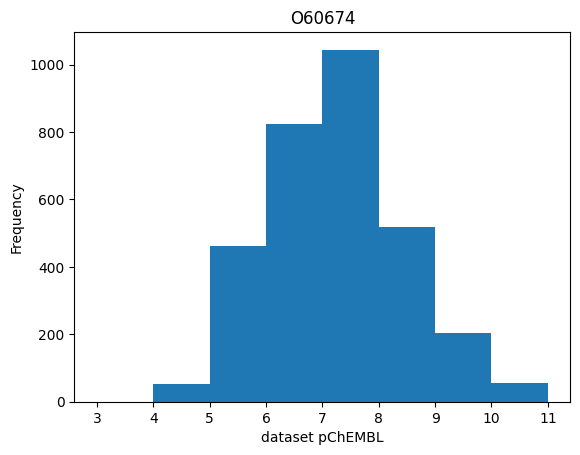

P00519


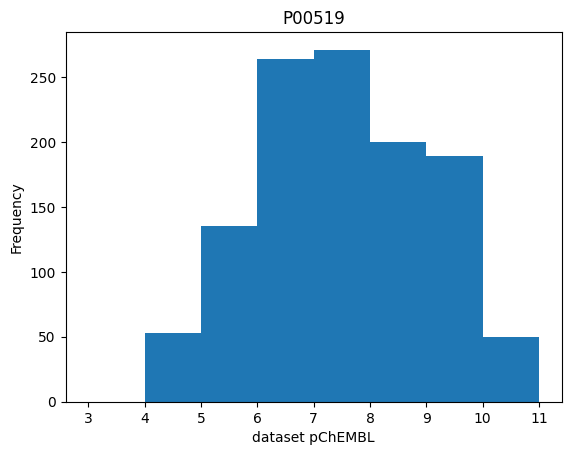

P00533


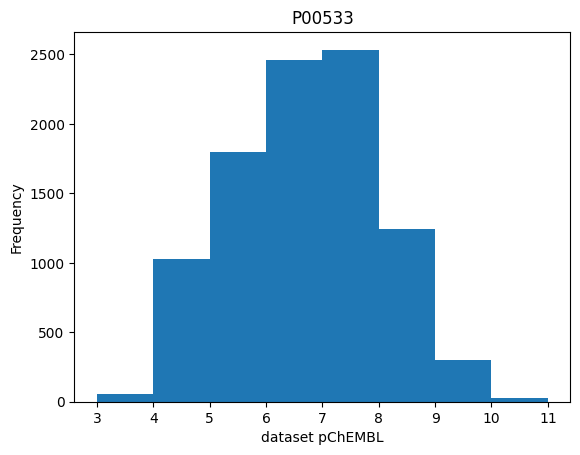

P04626


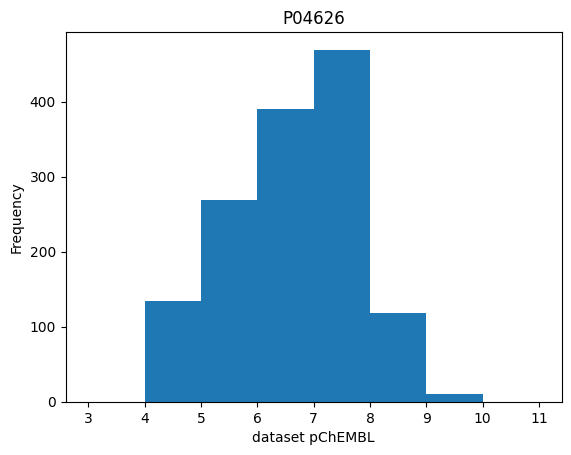

P07333


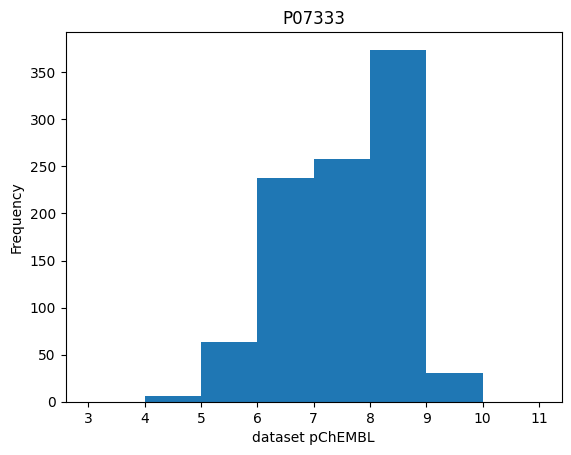

P08069


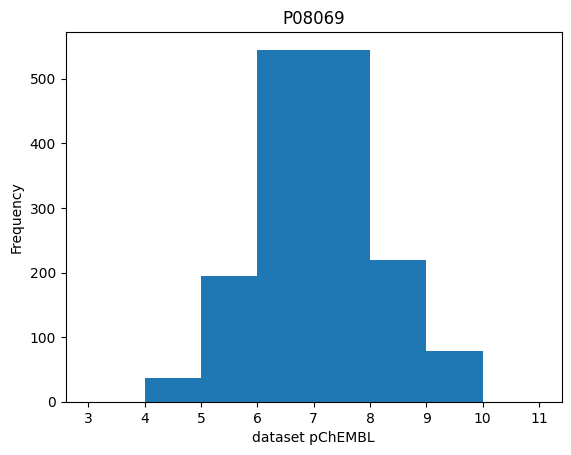

P08581


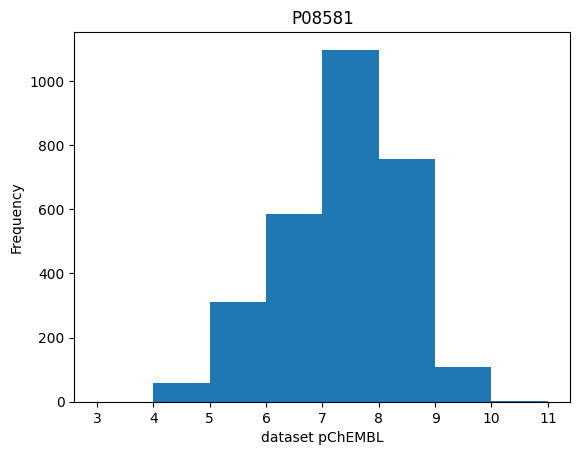

P11362


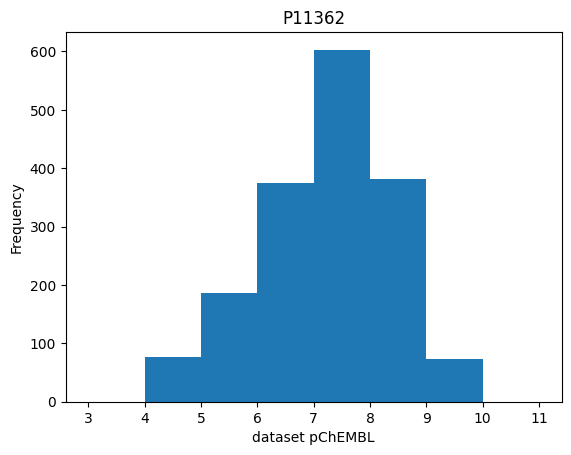

P12931


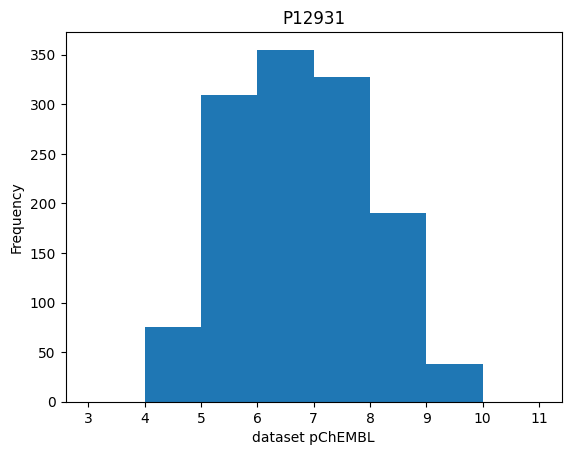

P21802


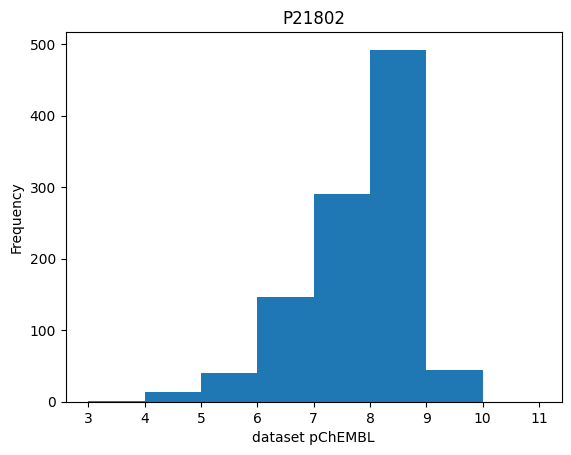

P22455


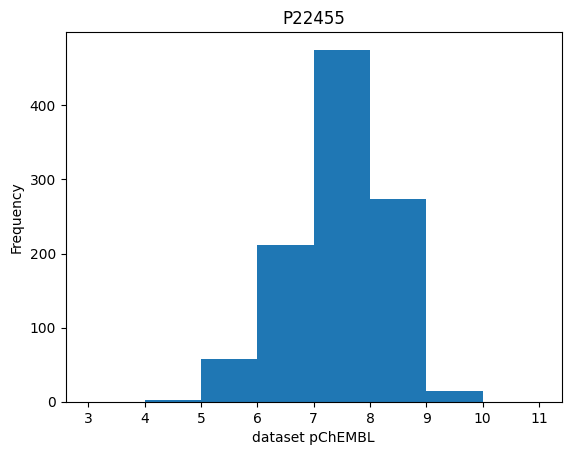

P22607


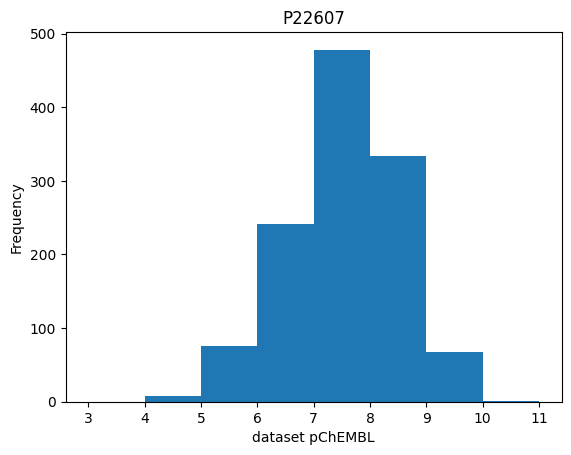

P23458


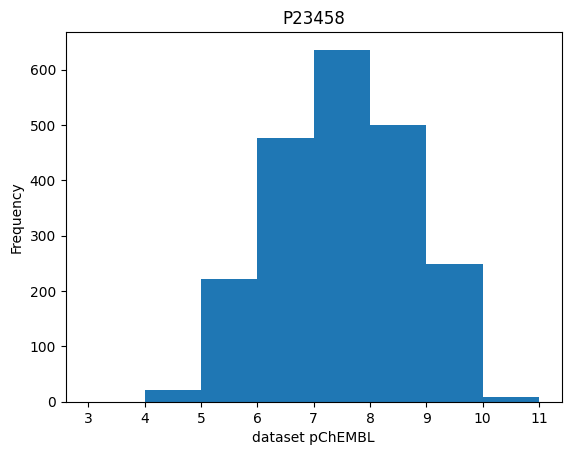

P29317


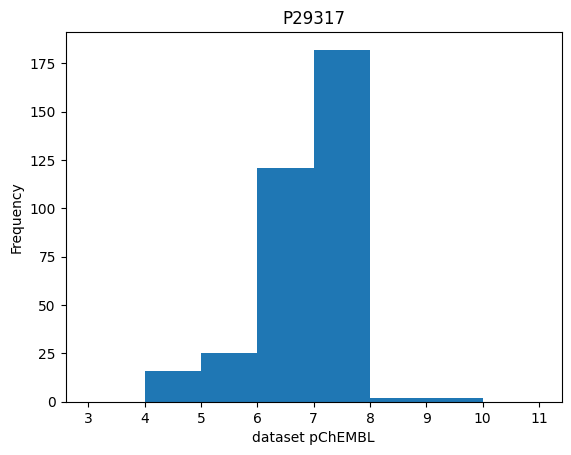

P29597


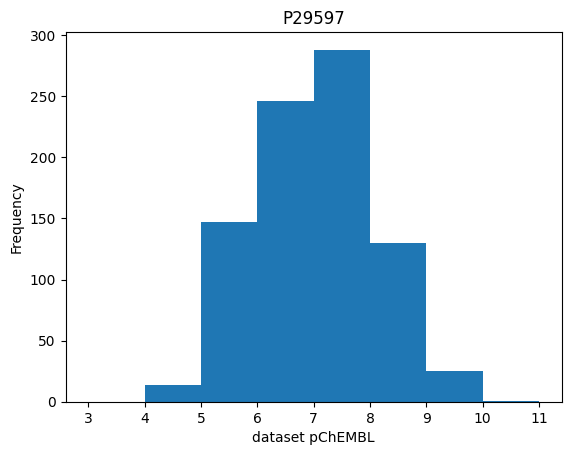

P30530


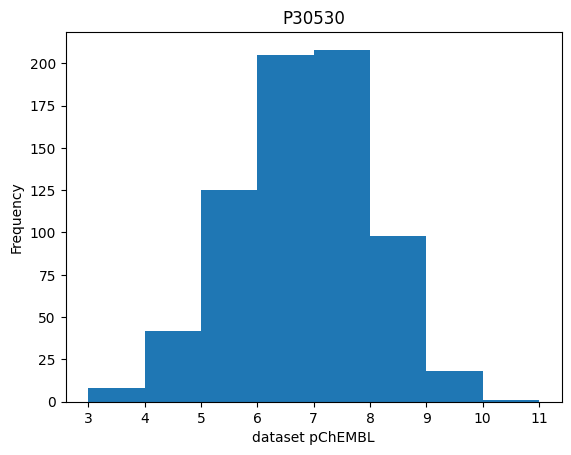

P35968


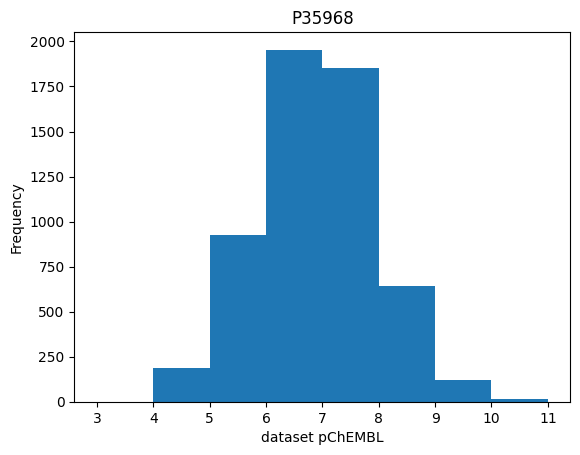

P36888


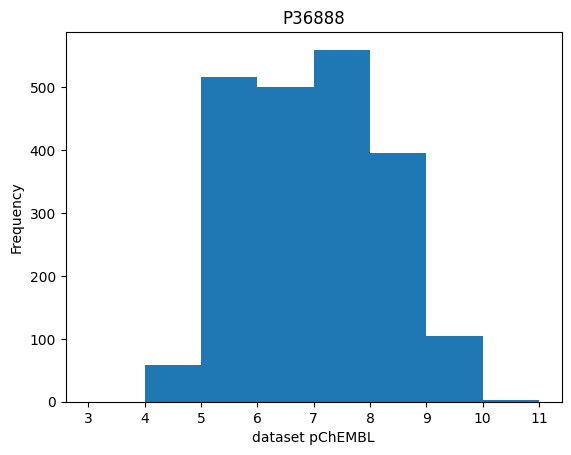

P43405


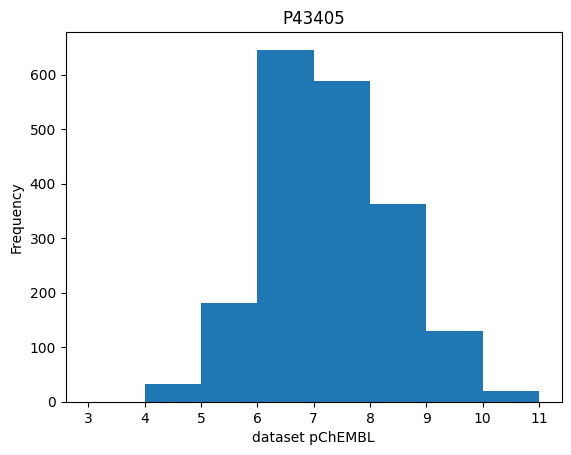

P52333


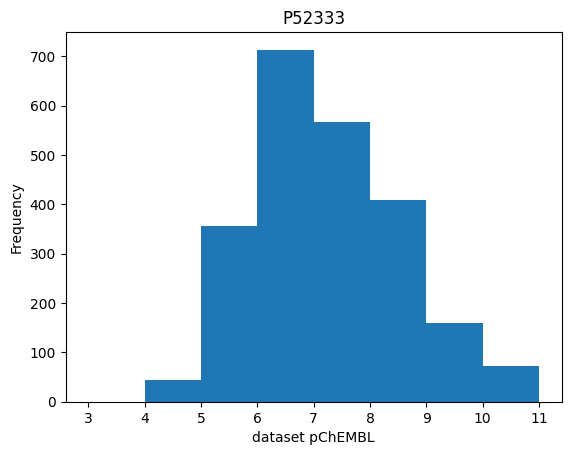

Q05397


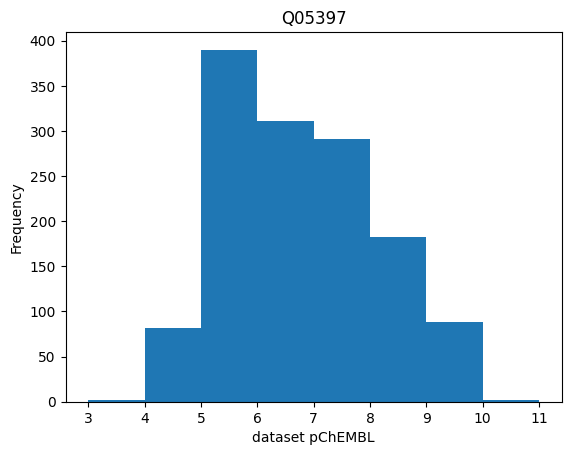

top targets


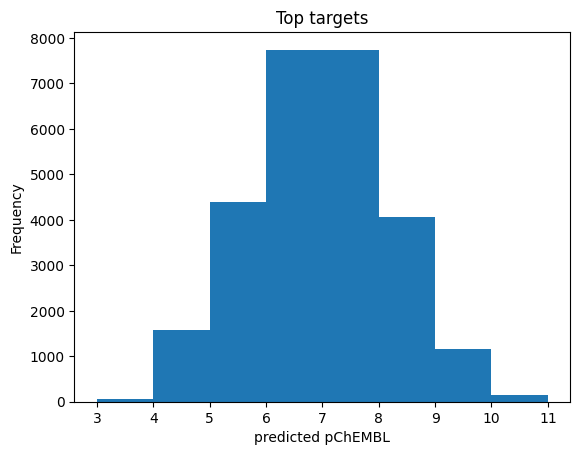

selected targets


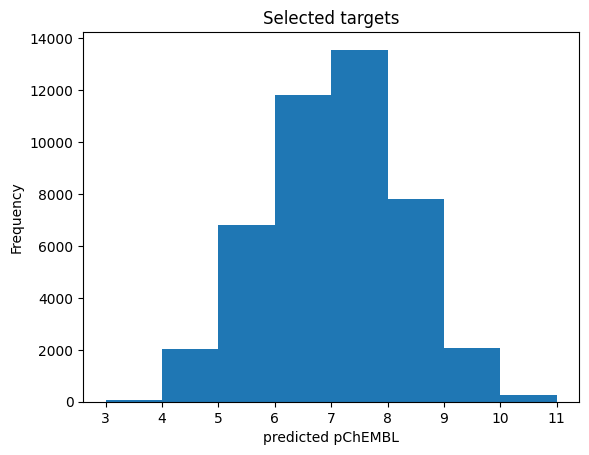

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
for target in selected_targets:
    print(f'{target}')
    pathvar = "/home/s2861704/ppk/test_kin/output/final/dataset/histograms/" + target + "_dist.png"
    df[f'{target}'].plot(kind = 'hist', bins=[3,4,5,6,7,8,9,10,11])
    # plt.ylim(2,12)
    plt.xlabel('dataset pChEMBL')
    # plt.ylabel('pChEMBL')
    plt.title(f'{target}')
    plt.savefig(pathvar)
    plt.show()

print("top targets")
df_top_single.plot(kind = 'hist', bins=[3,4,5,6,7,8,9,10,11], legend=False)
plt.xlabel('predicted pChEMBL')
plt.title('Top targets')
plt.savefig("/home/s2861704/ppk/test_kin/output/final/dataset/histograms/top-targets_dist.png")
plt.show()
print("selected targets")
df_sel_single.plot(kind = 'hist', bins=[3,4,5,6,7,8,9,10,11], legend=False)
plt.xlabel('predicted pChEMBL')
plt.title('Selected targets')
plt.savefig("/home/s2861704/ppk/test_kin/output/final/dataset/histograms/sel-targets_dist.png")
plt.show()

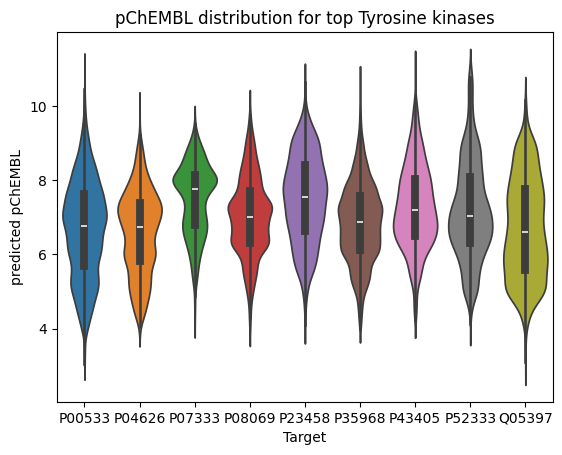

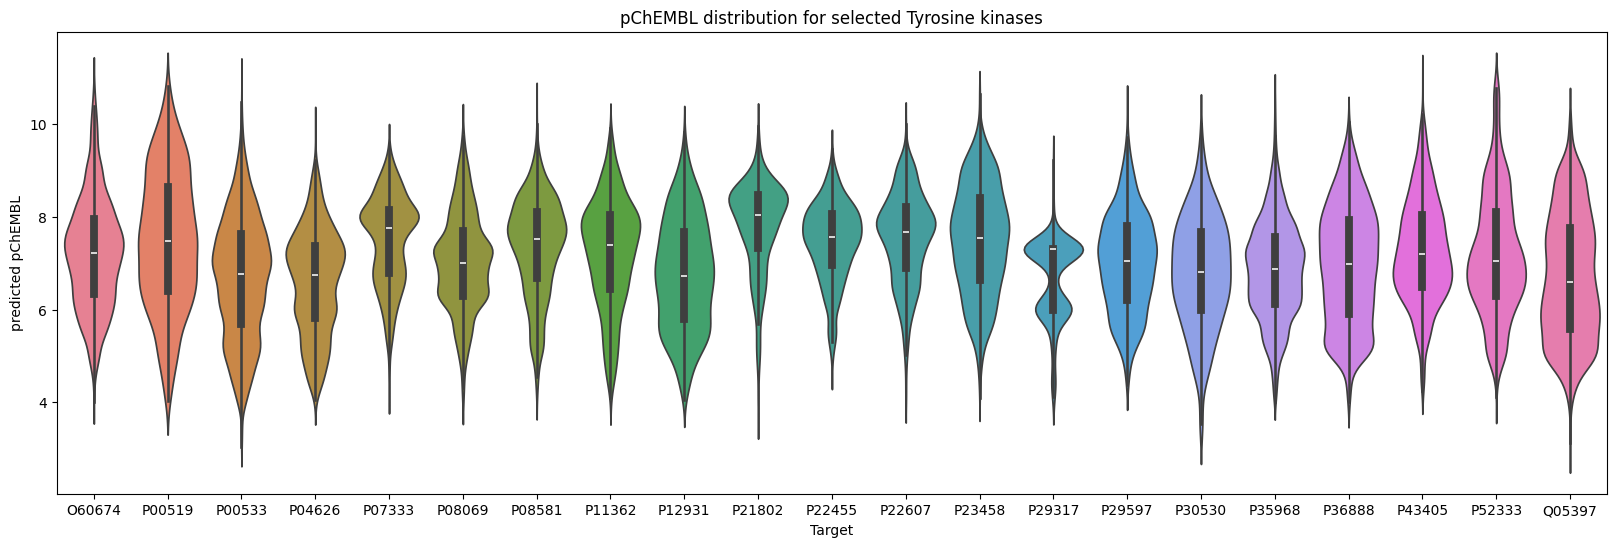

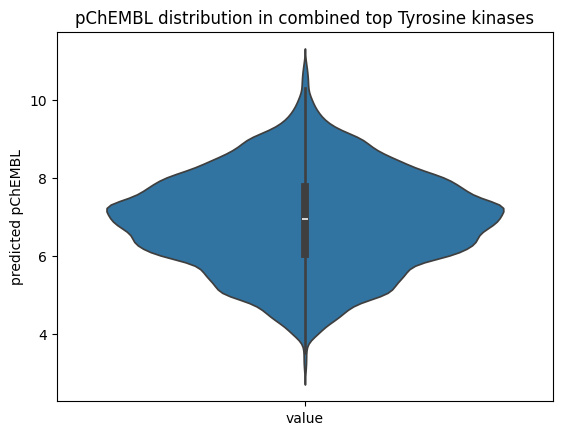

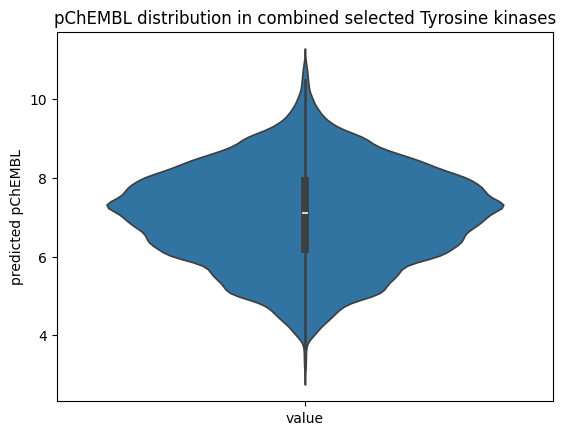

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# create violin plot for height (horizontal)
sns.violinplot(data=df[top_targets])
plt.xlabel('Target')
plt.ylabel('predicted pChEMBL')
plt.title('pChEMBL distribution for top Tyrosine kinases')
plt.savefig("/home/s2861704/ppk/test_kin/output/final/dataset/histograms/top-targets_violin.png") 
plt.show()

# create violin plot for height (horizontal)
plt.subplots(figsize=(20,6))
sns.violinplot(data=df[selected_targets])
plt.xlabel('Target')
plt.ylabel('predicted pChEMBL')
plt.title('pChEMBL distribution for selected Tyrosine kinases')
plt.savefig("/home/s2861704/ppk/test_kin/output/final/dataset/histograms/sel-targets_violin.png") 
plt.show()

# create violin plot for height (horizontal)
sns.violinplot(data=df_top_single)
plt.ylabel('predicted pChEMBL')
plt.title('pChEMBL distribution in combined top Tyrosine kinases')
plt.savefig("/home/s2861704/ppk/test_kin/output/final/dataset/histograms/top-targets-cmb_violin")
plt.show()

# create violin plot for height (horizontal)
sns.violinplot(data=df_sel_single)
plt.ylabel('predicted pChEMBL')
plt.title('pChEMBL distribution in combined selected Tyrosine kinases')
plt.savefig("/home/s2861704/ppk/test_kin/output/final/dataset/histograms/sel-targets-cmb_violin")
plt.show()

In [11]:
import numpy as np
for target in selected_targets:
    df_sel.loc[df_sel[target] < 6.5, target] = np.nan
display(df_sel)
for target in top_targets:
    df_top.loc[df_top[target] < 6.5, target] = np.nan
display(df_top)

/tmp/ipykernel_689059/1646539747.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sel.loc[df_sel[target] < 6.5, target] = np.nan


,O60674,P00519,P00533,P04626,P07333,P08069,P08581,P11362,P12931,P21802,...,P22607,P23458,P29317,P29597,P30530,P35968,P36888,P43405,P52333,Q05397
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,6.8,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,6.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.52,NaN,NaN
37000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.70,NaN,NaN
37001,NaN,NaN,NaN,NaN,NaN,7.3,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


/tmp/ipykernel_689059/1646539747.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top.loc[df_top[target] < 6.5, target] = np.nan


,P00533,P04626,P07333,P08069,P23458,P35968,P43405,P52333,Q05397
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,6.8,NaN,NaN,NaN,NaN,NaN
4,6.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
36999,NaN,NaN,NaN,NaN,NaN,NaN,6.52,NaN,NaN
37000,NaN,NaN,NaN,NaN,NaN,NaN,6.70,NaN,NaN
37001,NaN,NaN,NaN,7.3,NaN,NaN,NaN,NaN,NaN
37002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
list_numbers = list(range(1, 211)) # for top_targets: (1,37) / for selected_targets: (1,211)
df_chord_n = pd.DataFrame(list_numbers, columns = ['Numbers'])
print(df_chord_n)

     Numbers
0          1
1          2
2          3
3          4
4          5
..       ...
205      206
206      207
207      208
208      209
209      210

[210 rows x 1 columns]


In [13]:
sources_chord = selected_targets.copy()
targets_chord = selected_targets.copy()
sourcelist = []
targetlist = []
for source in sources_chord:
    print(source)
    del targets_chord[0]
    for target in targets_chord:
        sourcelist.append(source)
        targetlist.append(target)
print(sourcelist)
print(targetlist)

df_chord_n['source'] = sourcelist
df_chord_n['target'] = targetlist
df_chord = df_chord_n.drop(['Numbers'], axis=1)
display(df_chord)

O60674
P00519
P00533
P04626
P07333
P08069
P08581
P11362
P12931
P21802
P22455
P22607
P23458
P29317
P29597
P30530
P35968
P36888
P43405
P52333
Q05397
['O60674', 'O60674', 'O60674', 'O60674', 'O60674', 'O60674', 'O60674', 'O60674', 'O60674', 'O60674', 'O60674', 'O60674', 'O60674', 'O60674', 'O60674', 'O60674', 'O60674', 'O60674', 'O60674', 'O60674', 'P00519', 'P00519', 'P00519', 'P00519', 'P00519', 'P00519', 'P00519', 'P00519', 'P00519', 'P00519', 'P00519', 'P00519', 'P00519', 'P00519', 'P00519', 'P00519', 'P00519', 'P00519', 'P00519', 'P00533', 'P00533', 'P00533', 'P00533', 'P00533', 'P00533', 'P00533', 'P00533', 'P00533', 'P00533', 'P00533', 'P00533', 'P00533', 'P00533', 'P00533', 'P00533', 'P00533', 'P00533', 'P04626', 'P04626', 'P04626', 'P04626', 'P04626', 'P04626', 'P04626', 'P04626', 'P04626', 'P04626', 'P04626', 'P04626', 'P04626', 'P04626', 'P04626', 'P04626', 'P04626', 'P07333', 'P07333', 'P07333', 'P07333', 'P07333', 'P07333', 'P07333', 'P07333', 'P07333', 'P07333', 'P07333', 'P

,source,target
0,O60674,P00519
1,O60674,P00533
2,O60674,P04626
3,O60674,P07333
4,O60674,P08069
...,...,...
205,P36888,P52333
206,P36888,Q05397
207,P43405,P52333
208,P43405,Q05397


In [14]:
display(df_sel)

,O60674,P00519,P00533,P04626,P07333,P08069,P08581,P11362,P12931,P21802,...,P22607,P23458,P29317,P29597,P30530,P35968,P36888,P43405,P52333,Q05397
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,6.8,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,6.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.52,NaN,NaN
37000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.70,NaN,NaN
37001,NaN,NaN,NaN,NaN,NaN,7.3,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
weightlist = []
sources_chord_extra = selected_targets.copy()
targets_chord_extra = selected_targets.copy()
for source in sources_chord_extra:
    del targets_chord_extra[0]
    for target in targets_chord_extra:
        df_appendchord = df_sel.copy()
        df_appendchord1 = df_appendchord[df_appendchord[source].notna()]
        df_appendchord2 = df_appendchord1[df_appendchord1[target].notna()]
        weightvar = len(df_appendchord2.index)
        weightlist.append(weightvar)
print(weightlist)
print(len(weightlist))
print(min(weightlist))
print(max(weightlist))

[7, 9, 0, 4, 1, 2, 8, 6, 4, 1, 3, 1096, 2, 361, 3, 19, 40, 10, 865, 45, 14, 4, 10, 1, 5, 20, 96, 8, 5, 12, 3, 6, 2, 3, 18, 12, 2, 4, 2, 485, 29, 14, 18, 29, 20, 7, 6, 6, 0, 2, 2, 5, 225, 5, 0, 10, 3, 0, 6, 1, 4, 7, 4, 3, 4, 0, 36, 0, 0, 59, 1, 0, 4, 1, 0, 1, 12, 8, 10, 3, 7, 1, 2, 7, 2, 28, 55, 2, 4, 0, 3, 4, 2, 0, 0, 0, 1, 0, 0, 4, 3, 2, 0, 0, 3, 5, 9, 0, 1, 2, 0, 2, 0, 43, 124, 31, 0, 0, 1, 31, 554, 383, 497, 3, 1, 1, 1, 353, 24, 1, 3, 2, 18, 10, 16, 4, 5, 6, 10, 51, 11, 5, 6, 3, 561, 546, 2, 2, 3, 0, 234, 8, 2, 4, 1, 387, 1, 1, 0, 0, 195, 4, 0, 1, 0, 2, 1, 0, 1, 360, 17, 0, 2, 0, 1, 353, 0, 9, 20, 6, 682, 5, 1, 1, 134, 3, 0, 1, 2, 0, 14, 15, 1, 277, 4, 25, 78, 0, 0, 2, 162, 8, 20, 3, 8, 26, 3, 7, 3, 24]
210
0
1096


In [16]:
df_chord['weight'] = weightlist
display(df_chord)

,source,target,weight
0,O60674,P00519,7
1,O60674,P00533,9
2,O60674,P04626,0
3,O60674,P07333,4
4,O60674,P08069,1
...,...,...,...
205,P36888,P52333,26
206,P36888,Q05397,3
207,P43405,P52333,7
208,P43405,Q05397,3


In [17]:
df_chord.to_csv(path_or_buf='/home/s2861704/ppk/test_kin/output/final/dataset/dataset_chord.csv', sep=',', index=False)

In [26]:
from d3blocks import D3Blocks
d3 = D3Blocks(chart='Chord', frame=False)
d3.set_node_properties(df_chord, opacity=0.5, cmap='tab20')
d3.set_edge_properties(df_chord, color='source', opacity='source')
d3.show(filepath='/home/s2861704/ppk/test_kin/output/final/dataset/chord/d3blocks.html')

[d3blocks] >INFO> Cleaning edge_properties and config parameters..
[d3blocks] >INFO> Initializing [Chord]
[d3blocks] >INFO> filepath is set to [/tmp/d3blocks/chord.html]
[d3blocks] >INFO> Node properties are set.
[d3blocks] >INFO> Edge properties are set.
[d3blocks] >INFO> Set [filepath]: /home/s2861704/ppk/test_kin/output/final/dataset/chord/d3blocks.html
[d3blocks] >INFO> Open browser: /home/s2861704/ppk/test_kin/output/final/dataset/chord/d3blocks.html
